# LSTM (Left Wrist)

In [3317]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3318]:
df = pd.read_csv('acc_data (left_wrist).csv')
print(df.head())
df = df.drop([0])
print(df.head())

   PacketCounter     Acc_X     Acc_Y     Acc_Z Unnamed: 11
0              0  0.000000  0.000000  0.000000            
1              1 -4.997346 -3.298741  6.276892            
2              2 -4.860229 -2.856503  5.838315            
3              3 -4.415420 -2.575201  5.332450            
4              4 -4.558330 -2.955828  5.380980            
   PacketCounter     Acc_X     Acc_Y     Acc_Z Unnamed: 11
1              1 -4.997346 -3.298741  6.276892            
2              2 -4.860229 -2.856503  5.838315            
3              3 -4.415420 -2.575201  5.332450            
4              4 -4.558330 -2.955828  5.380980            
5              5 -4.934264 -3.140786  5.319851            


In [3319]:
df.shape

(404, 5)

In [3320]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

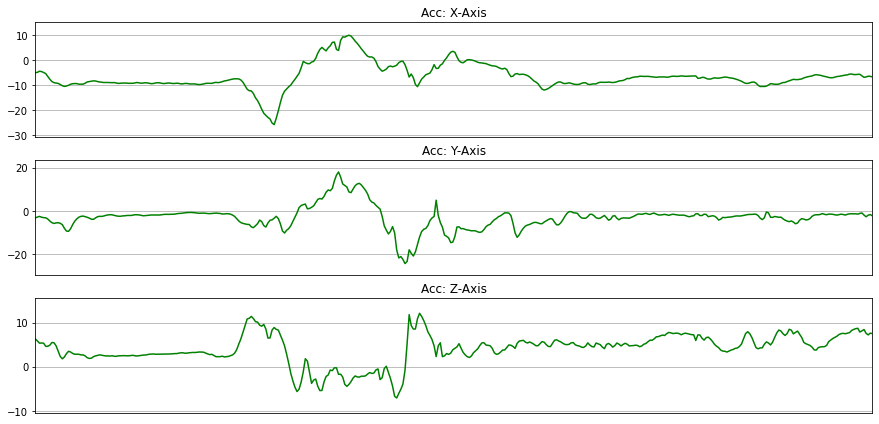

In [3321]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis(ax0, df['PacketCounter'], df['Acc_X'], 'Acc: X-Axis')
plot_axis(ax1, df['PacketCounter'], df['Acc_Y'], 'Acc: Y-Axis')
plot_axis(ax2, df['PacketCounter'], df['Acc_Z'], 'Acc: Z-Axis')
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(top=0.90)
plt.show()

In [3322]:
X = df[['Acc_X', 'Acc_Y', 'Acc_Z']]
y = df['PacketCounter']

In [3323]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['Acc_X', 'Acc_Y', 'Acc_Z'])
scaled_X['PacketCounter'] = y.values

scaled_X.head()

,Acc_X,Acc_Y,Acc_Z,PacketCounter
0,0.315972,-0.047011,0.655104,1
1,0.342935,0.035195,0.526981,2
2,0.430405,0.087486,0.379201,3
3,0.402303,0.016732,0.393378,4
4,0.328376,-0.017649,0.375520,5


In [3324]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = scaled_X['PacketCounter'].iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 100 #400 #200 #300
STEP = 50  #100 #60 #80 #40 #150

X_train, y_train = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

In [3325]:
print(X_train.shape, y_train.shape)

(354, 50, 3) (354, 1)


In [3326]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [3327]:
print(X_train.shape, y_train.shape)

(354, 50, 3) (354, 354)


In [3328]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [3329]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128, #64 #128 #32
    validation_split=0.1,
    shuffle=True
)

Train on 318 samples, validate on 36 samples
Epoch 1/100
318/318 [==============================] - 4s 12ms/sample - loss: 5.9354 - acc: 0.0000e+00 - val_loss: 5.9650 - val_acc: 0.0000e+00
Epoch 2/100
318/318 [==============================] - 1s 3ms/sample - loss: 5.8779 - acc: 0.0000e+00 - val_loss: 6.0130 - val_acc: 0.0000e+00
Epoch 3/100
318/318 [==============================] - 1s 3ms/sample - loss: 5.8254 - acc: 0.0063 - val_loss: 6.0553 - val_acc: 0.0000e+00
Epoch 4/100
318/318 [==============================] - 1s 3ms/sample - loss: 5.7872 - acc: 0.0031 - val_loss: 6.1040 - val_acc: 0.0000e+00
Epoch 5/100
318/318 [==============================] - 1s 3ms/sample - loss: 5.7470 - acc: 0.0094 - val_loss: 6.1707 - val_acc: 0.0000e+00
Epoch 6/100
318/318 [==============================] - 1s 3ms/sample - loss: 5.6888 - acc: 0.0063 - val_loss: 6.2634 - val_acc: 0.0000e+00
Epoch 7/100
318/318 [==============================] - 1s 3ms/sample - loss: 5.6474 - acc: 0.0126 - val_loss: 6.

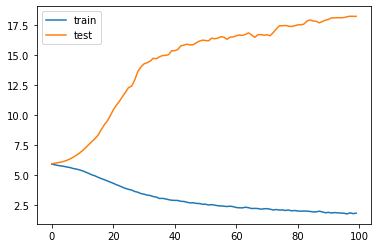

In [3330]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

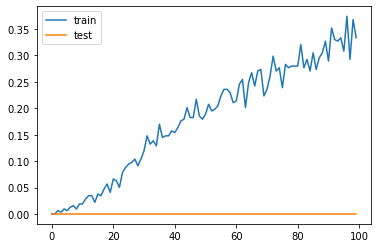

In [3331]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

In [3332]:
model.evaluate(X_test, y_test)

354/354 [==============================] - 0s 1ms/sample - loss: 3.2755 - acc: 0.4633


[3.2754924149163025, 0.46327683]

In [3333]:
model.evaluate(X_train, y_train)

354/354 [==============================] - 0s 1ms/sample - loss: 3.2755 - acc: 0.4633


[3.2754924149163025, 0.46327683]

# SVM

In [47]:
print('Mean (X):', np.mean(X_train))
print('Standard Deviation (X):', np.std(X_train))

print('\nMean (y):', np.mean(y_train))
print('Standard Deviation (y):', np.std(y_train))

Mean (X): -1.7760826385281714
Standard Deviation (X): 6.801635082335362

Mean (y): 0.003937007874015748
Standard Deviation (y): 0.06262194378183805


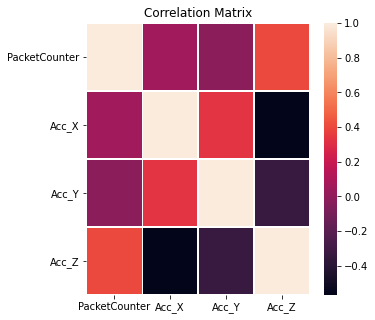

In [48]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(corr, linewidth=0.5)
plt.title('Correlation Matrix')
plt.show()

In [53]:
df_train = df[df['PacketCounter'] <= 30]
df_test = df[df['PacketCounter'] > 30]

In [54]:
X = df[['Acc_X', 'Acc_Y', 'Acc_Z']]
y = df['PacketCounter']

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['Acc_X', 'Acc_Y', 'Acc_Z'])
scaled_X['PacketCounter'] = y.values

scaled_X.head()

,Acc_X,Acc_Y,Acc_Z,PacketCounter
0,1.294386,0.565261,-1.175115,0
1,0.312502,-0.048450,0.657701,1
2,0.339443,0.033826,0.529639,2
3,0.426839,0.086160,0.381929,3
4,0.398760,0.015347,0.396100,4


In [22]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = scaled_X['PacketCounter'].iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 300
STEP =  150

X_train, y_train = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

In [23]:
print(X_train.shape, y_train.shape)

(255, 150, 3) (255, 1)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [ ]:
print(X_train.shape, y_train.shape)

In [ ]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[0], X_train.shape[1]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [29]:
model.evaluate(X_test, y_test)

255/255 [==============================] - 0s 794us/sample - loss: 4.1742 - acc: 0.1176


[4.174206314834894, 0.11764706]